In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MaxAbsScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

In [7]:
# Import the excel spreadsheets in the data folder
installer_df = pd.read_excel('../data/Installer.xlsx')
involver_df = pd.read_excel('../data/Involver.xlsx')

c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\nlp_risk_prediction\nlp_env\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)
c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\nlp_risk_prediction\nlp_env\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


In [8]:
# Attempt to merge using a subset of key columns
merge_on_columns = ['Site', 'Vessel_Name', 'Wo_No']

df = pd.concat([installer_df, involver_df], axis=0)

# feature_columns = ['Object', 'Group', 'Symptom', 'Error_Cause', 'Cause_Details', 'Error_Class', 'Discovery', 'Completion_Note', 'Action_Taken', 'Work_Description', 'Directive']
feature_columns = ['Object', 'Group', 'Object_Type','Completion_Note', 'Work_Description', 'Directive']
# TODO: Change this to ESB1
target_column = 'EBS1'

# Filter the dataframe for the selected columns
df = df[feature_columns + [target_column]].dropna()

In [9]:
# Convert the target column to ids 
# Encode the target column
label_encoder = LabelEncoder()
df[target_column] = label_encoder.fit_transform(df[target_column].astype(str))
df[target_column].dtype, df[target_column].unique()

(dtype('int64'),
 array([24,  2, 13,  5, 25, 12, 10,  4, 20,  8, 21, 28, 29,  9, 15, 17,  1,
         3, 18, 19, 26, 11,  0,  7, 22, 23, 14,  6, 27, 16]))

In [10]:
# Define the TF-IDF vectorizer for text columns
preprocessor = ColumnTransformer(
    transformers=[
        (col, TfidfVectorizer(), col) for col in feature_columns
    ], remainder='drop'  # Dropping non-specified columns, though all columns are specified here
)

# Create a pipeline with preprocessor, scaler, and MLPClassifier
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', MaxAbsScaler()),  # Apply scaler after TF-IDF transformation
    ('classifier', MLPClassifier(random_state=42, verbose=True))
])

# Define parameter grid for hyperparameter tuning
param_grid = {
    'classifier__hidden_layer_sizes': [(50, 50), (100,), (100, 50), (100, 100)],
    'classifier__activation': ['tanh', 'relu'],
    'classifier__solver': ['adam', 'sgd'],
    'classifier__alpha': [0.0001, 0.001, 0.01],
    'classifier__learning_rate': ['constant', 'adaptive'],
    'classifier__max_iter': [200, 500]
}

# Split the data into training and testing sets
X = df[feature_columns]
y = df[target_column]

# Check if the length of X and y are consistent
assert len(X) == len(y), "Mismatch in the number of samples between X and y"

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training samples: ", X_train.shape, "Testing samples: ", X_test.shape)
print("Training labels: ", y_train.shape, "Testing labels: ", y_test.shape)

# Initialize GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, n_jobs=-1, cv=3, scoring='accuracy', verbose=2)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation accuracy: ", grid_search.best_score_)

Training samples:  (487, 6) Testing samples:  (122, 6)
Training labels:  (487,) Testing labels:  (122,)
Fitting 3 folds for each of 192 candidates, totalling 576 fits


c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\nlp_risk_prediction\nlp_env\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Iteration 1, loss = 3.29090223
Iteration 2, loss = 2.63550054
Iteration 3, loss = 2.01381516
Iteration 4, loss = 1.45977350
Iteration 5, loss = 1.03378075
Iteration 6, loss = 0.76243218
Iteration 7, loss = 0.59184599
Iteration 8, loss = 0.47523223
Iteration 9, loss = 0.38697306
Iteration 10, loss = 0.31829765
Iteration 11, loss = 0.26171520
Iteration 12, loss = 0.21962776
Iteration 13, loss = 0.18503225
Iteration 14, loss = 0.15854861
Iteration 15, loss = 0.13677594
Iteration 16, loss = 0.11974292
Iteration 17, loss = 0.10476395
Iteration 18, loss = 0.09318586
Iteration 19, loss = 0.08351195
Iteration 20, loss = 0.07583540
Iteration 21, loss = 0.06949467
Iteration 22, loss = 0.06424960
Iteration 23, loss = 0.05969528
Iteration 24, loss = 0.05598054
Iteration 25, loss = 0.05246742
Iteration 26, loss = 0.04961931
Iteration 27, loss = 0.04698490
Iteration 28, loss = 0.04483797
Iteration 29, loss = 0.04286384
Iteration 30, loss = 0.04099403
Iteration 31, loss = 0.03941241
Iteration 32, los

Test accuracy:  0.8524590163934426
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         1
           2       0.96      1.00      0.98        25
           3       0.00      0.00      0.00         1
           4       0.60      1.00      0.75         3
           5       0.73      0.96      0.83        25
           7       1.00      1.00      1.00         1
           8       0.50      1.00      0.67         2
           9       1.00      0.33      0.50         3
          10       1.00      0.67      0.80         3
          12       1.00      1.00      1.00         2
          13       1.00      0.93      0.96        29
          14       1.00      1.00      1.00         1
          16       0.00      0.00      0.00         1
          17       1.00      0.20      0.33         5
          20       0.33      1.00      0.50         1
          21       1.00

c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\nlp_risk_prediction\nlp_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\nlp_risk_prediction\nlp_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\nlp_risk_prediction\nlp_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set

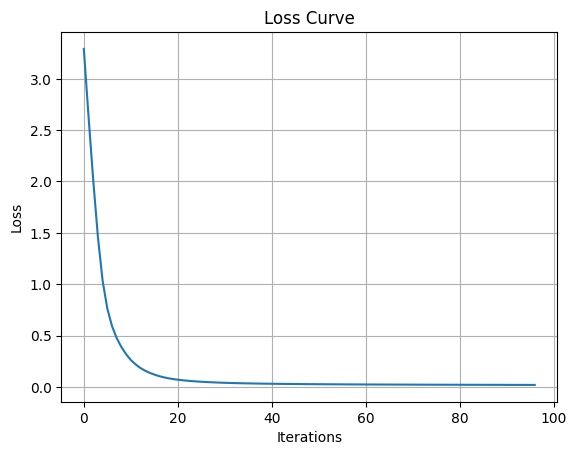

In [11]:
# Evaluate on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print("Test accuracy: ", test_accuracy)

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plot the loss curve
classifier = best_model.named_steps['classifier']
plt.plot(classifier.loss_curve_)
plt.title('Loss Curve')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.grid()
plt.show()